# CPSC 533R Visual AI - Assignment 1

---
**Group 5**

Muchen Li

Atabak Eghbal


---



#Importing Necessary Libraries 

In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import random

# Use standard FashionMNIST dataset
def gray_to_color(x):
    return x.repeat(3, 1, 1)

#A Minor Modification in The Resnet Library

Changed the Conv2d input from 3 to 6 for the coupled image problem for conv1

In [2]:
from torchvision.models.resnet import BasicBlock, conv3x3, conv1x1
class ResNet_compare(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet_compare, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(6, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)
    
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet_compare(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

## Tasks 1-3 Data Handling

In [3]:
class wrappedMinistDataset:
    
    def __init__(self, root, train, download, transform):
        self.mnistDataset = torchvision.datasets.MNIST(
                                root = root,
                                train = train,
                                download = download,
                                transform = transform
                            )
        
    def __getitem__(self, index):
        img, label = self.mnistDataset.__getitem__(index)
        return {"img": img, "class": label}
    
    def __len__(self):
        return self.mnistDataset.__len__()

class modelRes18(nn.Module):
    def __init__(self, num_classes=10):
        super(modelRes18, self).__init__()
        self.backbone = torchvision.models.resnet18(num_classes=num_classes)
    
    def forward(self, input_dict):
        tensor = input_dict["img"]
        preds = self.backbone(tensor)
        return {"class": preds}

def train_process(model, train_set, batch_size=32, cuda=True):
    loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, num_workers=0)
    iterator = iter(loader)
    losses = []
    if cuda:
        model = model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    for i in range(200): #range(len(loader)):
        batch = next(iterator)
        if cuda:
            for k, v in batch.items():
                batch[k] = v.cuda()
        preds = model(batch)
        loss = nn.functional.cross_entropy(preds["class"], batch["class"])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i%20==0:
            print(i,losses[-1])
    plt.plot(losses)

Extracting ./DatasetMNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./DatasetMNIST/MNIST/raw



Extracting ./DatasetMNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./DatasetMNIST/MNIST/raw


Extracting ./DatasetMNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./DatasetMNIST/MNIST/raw


Extracting ./DatasetMNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./DatasetMNIST/MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


0 2.6441378593444824
20 1.9959341287612915
40 1.7127513885498047
60 1.2700623273849487
80 1.0887272357940674
100 0.8413546085357666
120 0.8801267147064209
140 0.9504836201667786
160 0.6683540940284729
180 0.599208414554596


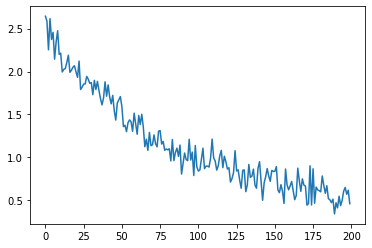

In [4]:
train_set = wrappedMinistDataset(
    root = './DatasetMNIST',
    train = True,
    download = True ,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
)
model = modelRes18(num_classes=10).cuda()
train_process(model, train_set)

## Tasks 4-5

In [5]:
RANDOM_SEED = 503
# Task 4 here
class pairWiseMinistDataset:
    def __init__(self, 
                 root, 
                 train, 
                 download, 
                 transform, 
                 random_seed=RANDOM_SEED, 
                 dataset_length=10000):
        self.mnistDataset = torchvision.datasets.MNIST(
                                root = root,
                                train = train,
                                download = download,
                                transform = transform
                            )
        random.seed(random_seed)
        self.dataset_length = dataset_length
        self.mnist_size = self.mnistDataset.__len__()
        self.index2pair = random.sample(range(self.mnist_size * self.mnist_size), dataset_length)
        
    def __getitem__(self, index):
        pair_index = self.index2pair[index]
        index1 = pair_index // self.mnist_size
        index2 = pair_index % self.mnist_size
        img1, label1 = self.mnistDataset.__getitem__(index1)
        img2, label2 = self.mnistDataset.__getitem__(index2)
        label = 1. if label1 == label2 else 0.
        return {"img1": img1, "img2": img2, "class": label}
    
    def __len__(self):
        return self.dataset_length

# Task 5 here
# Found out by expriment early fusion of the two images works much better than late fusion! Which makes perfectly sense!
class pairWiseModelEarlyFusion(nn.Module):
    def __init__(self, 
                 backbone = resnet18):
        super(pairWiseModelEarlyFusion, self).__init__()
        self.backbone = backbone(num_classes=1)
    
    def forward(self, input_dict):
        img1 = input_dict["img1"]
        img2 = input_dict["img2"]
        cated_img = torch.cat([img1, img2], dim=1)
        preds = self.backbone(cated_img)
        preds = torch.sigmoid(preds).squeeze()
        return {"class": preds}

# class pairWiseModel(nn.Module):
#     def __init__(self, 
#                  backbone = torchvision.models.resnet18, 
#                  num_embedding = 256):
#         super(pairWiseModel, self).__init__()
#         self.backbone = backbone(num_classes=num_embedding)
#         self.classifier = nn.Linear(num_embedding*2, 1)
    
#     def forward(self, input_dict):
#         img1 = input_dict["img1"]
#         img2 = input_dict["img2"]
#         feature_img1 = self.backbone(img1)
#         feature_img2 = self.backbone(img2)
#         stacked_feature = torch.cat([feature_img1, feature_img2], dim=1)
#         preds = self.classifier(stacked_feature).squeeze()
#         preds = torch.sigmoid(preds)
#         return {"class": preds}

##Task 6-7 

In [6]:
LOG_CYCLE = 500
VALIDATION_CYCLE = 2000
MAX_EPOCH = 5
MAX_ITER = 20000

def to_cuda(d: dict):
    for k, v in d.items():
        d[k] = v.cuda()

def get_accuracy(preds, gt):
    logits = preds["class"]
    pred_label = torch.round(logits).int()
    acc = (pred_label == gt).sum().float() * 1.0 / pred_label.shape[0]
    return acc * 100

def test(model, test_loader, cuda=True):
    model.eval()
    accs = []
    for batch in test_loader:
        if cuda:
            to_cuda(batch)
        preds = model(batch)
        accs.append(get_accuracy(preds, batch["class"]))
        
    # simply save the last batch for now
    val_img_sample = {"data": batch, "pred": preds}
    avg_acc = sum(accs) / len(accs)
    model.train()
    return avg_acc, val_img_sample


def train_and_test(model, train_set, val_set, test_set, batch_size=32, cuda=True):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=0)
    train_iter = iter(train_loader)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=0)
    val_iter = iter(val_loader)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=0)
    test_iter = iter(test_loader)

    losses = []
    val_accs = []
    val_img_samples = []
    train_img_samples = []
    if cuda:
        model = model.cuda()
    # Chage to Adam for better performace
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.4*MAX_ITER),int(0.9*MAX_ITER)], gamma=0.1)
    gs  =  0
    for epoch in range(MAX_EPOCH):
        for batch in train_loader:
            # Preaparing Data 
            if cuda:
                to_cuda(batch)
            # Forward model
            preds = model(batch)
            # Task 6 here, more losses to be try out
            loss = nn.functional.binary_cross_entropy(preds["class"], batch["class"].float())
            # Backprop and Update Prams
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()    
            
            # Logging 
            losses.append(loss.item())
            if gs % LOG_CYCLE == 0:
                print(gs,losses[-1])
        
            if gs % VALIDATION_CYCLE == 0:
                # Simply save the last batch for now
                train_img_samples.append({"data": batch, "pred": preds})

                # Taks7: DO Validation here
                avg_acc, img_sample = test(model, val_loader, cuda=cuda)
                val_accs.append(avg_acc.item())
                val_img_samples.append(img_sample)
                print("Validatoin acc: %.4f%%" % (avg_acc))
            gs += 1
            if gs > MAX_ITER:
                break
    
    test_acc, _ = test(model, test_loader)
    print("Test acc: %.4f%%" % (test_acc.item()))
    
    return {"losses": losses, "val_accs": val_accs, "test_acc": test_acc, "train_img_samples": train_img_samples, "val_img_samples": val_img_samples}
 

## Tasks6-7 Continued ---- Grabbing The Train+Test sets  ----  & ----   Splitting Train set to Train + Val  ----- & ----- Train!

In [7]:
# Some settings for train val split
full_set_length = 2000000
test_set_length = 2000
val_split = int(0.05 * full_set_length)
train_split = full_set_length - val_split

# Build full set and test set
full_train_set = pairWiseMinistDataset(
    root = './DatasetMNIST',
    train = True,
    download = False ,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ]),
    random_seed=RANDOM_SEED, 
    dataset_length=full_set_length
)
test_set = pairWiseMinistDataset(
    root = './DatasetMNIST',
    train = False,
    download = False ,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ]),
    random_seed=RANDOM_SEED, 
    dataset_length=test_set_length
)
# Taks7 Split Validation subset
train_set, val_set = torch.utils.data.random_split(full_train_set, [train_split, val_split], generator=torch.Generator().manual_seed(RANDOM_SEED))
# build model
# model = pairWiseModel(backbone=torchvision.models.resnet18, num_embedding=256)
model = pairWiseModelEarlyFusion(backbone=resnet18)
# train, val and test
data_dict = train_and_test(model, 
                           train_set = train_set, 
                           val_set = val_set, 
                           test_set = test_set, 
                           batch_size = 64, 
                           cuda = True)

0 0.6835033297538757
Validatoin acc: 84.7499%
500 0.08800695091485977
1000 0.1576116979122162
1500 0.20044970512390137
2000 0.09662950038909912
Validatoin acc: 96.4371%
2500 0.10354271531105042
3000 0.11787807196378708
3500 0.03595542162656784
4000 0.09587112069129944
Validatoin acc: 97.7117%
4500 0.10281240195035934
5000 0.025336356833577156
5500 0.013227645307779312
6000 0.023292748257517815
Validatoin acc: 98.1946%
6500 0.07116775214672089
7000 0.019880089908838272
7500 0.013707686215639114
8000 0.013009581714868546
Validatoin acc: 98.5375%
8500 0.07247406244277954
9000 0.10987130552530289
9500 0.033893171697854996
10000 0.010456535965204239
Validatoin acc: 99.0253%
10500 0.025508012622594833
11000 0.005821182858198881
11500 0.002450718078762293
12000 0.02674269676208496
Validatoin acc: 99.1103%
12500 0.0714276060461998
13000 0.07341901957988739
13500 0.022550001740455627
14000 0.007144097704440355
Validatoin acc: 99.1533%
14500 0.04877474159002304
15000 0.011338837444782257
15500 0

## Tasks 8-10 Visualization 

In [10]:
train_img_samples = data_dict["train_img_samples"]
val_img_samples = data_dict["val_img_samples"]
vis_epoch = 6
import numpy as np
%matplotlib inline
def show(img, row, col, i, fig):
    npimg = img.numpy()
    fig.add_subplot(row, col, i)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def vis_img(samples):
    img1 = samples["data"]["img1"].cpu()
    img2 = samples["data"]["img2"].cpu()
    pred = torch.round(samples["pred"]["class"]).cpu().int()
    
    width = 16
    img1 = img1[:width]
    img2 = img2[:width]
    img1 = torchvision.utils.make_grid(img1, nrow=width)
    img2 = torchvision.utils.make_grid(img2, nrow=width)
    fig = plt.figure()
    show(img1, 1, 1, 1, fig)
    show(img2, 2, 1, 2, fig)
    print(list(pred[:width].detach().numpy()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


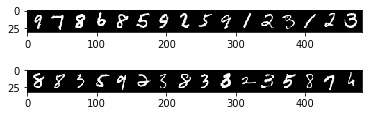

In [11]:
vis_img(train_img_samples[vis_epoch])

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


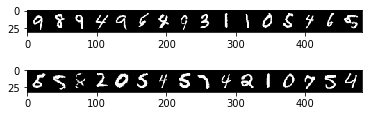

In [12]:
vis_img(val_img_samples[vis_epoch])

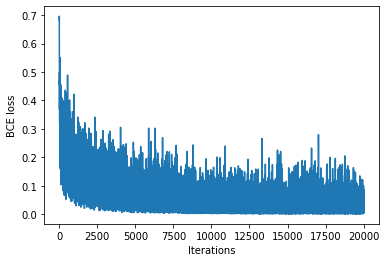

In [13]:
plt.plot(data_dict["losses"])
plt.xlabel("Iterations")
plt.ylabel("BCE loss")
plt.show()

## Optional Add-ons

### Bonus 1   - Making the Plot Smooth 

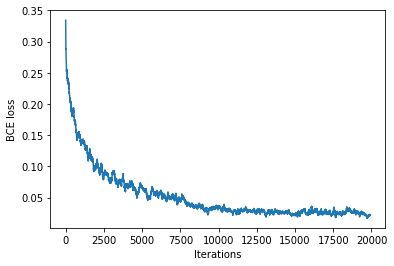

In [14]:
# Smoothed version
def smooth(datas, window_size=100):
    x = [datas[i:i+window_size] for i in range(len(datas)-window_size)]
    x = [sum(tmp)/window_size for tmp in x]
    return x
plt.plot(smooth(data_dict["losses"]))
plt.xlabel("Iterations")
plt.ylabel("BCE loss")
plt.show()

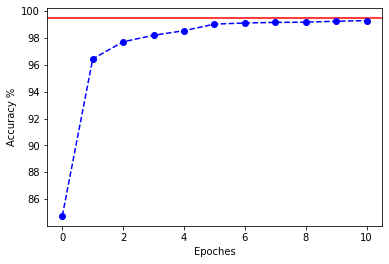

In [15]:
plt.axhline(data_dict["test_acc"], color='r')
plt.plot(data_dict["val_accs"],  linestyle='--', marker='o', color='b')
# plt.xticks(np.arange(MAX_EPOCH))
# plt.yticks(np.arange(85, 100))
plt.xlabel("Epoches")
plt.ylabel("Accuracy %")
plt.show()

### Bounus 2 --- The effect of Dictionaries on Computational Time

In [16]:
import time
class wrappedMinistDatasetNoneDict:
    
    def __init__(self, root, train, download, transform):
        self.mnistDataset = torchvision.datasets.MNIST(
                                root = root,
                                train = train,
                                download = download,
                                transform = transform
                            )
        
    def __getitem__(self, index):
        img, label = self.mnistDataset.__getitem__(index)
        return img, label
    
    def __len__(self):
        return self.mnistDataset.__len__()

train_set = wrappedMinistDataset(
    root = './DatasetMNIST',
    train = True,
    download = False ,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
)
train_loader_iter = iter(torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=0))
train_set_none_dict = wrappedMinistDataset(
    root = './DatasetMNIST',
    train = True,
    download = False ,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
)
train_loader_none_dict_iter = iter(torch.utils.data.DataLoader(train_set_none_dict, batch_size=32, num_workers=0))

t1 = time.perf_counter()
for i in range(1000):
    batch = next(train_loader_iter)
t2 = time.perf_counter()

t3 = time.perf_counter()
for i in range(1000):
    batch = next(train_loader_none_dict_iter)
t4 = time.perf_counter()

print("With dict: {}".format(t2-t1))
print("Without dict: {}".format(t4-t3))

With dict: 2.448339216000022
Without dict: 2.370802251999976
